LISA
====

**LISA: Reasoning Segmentation via Large Language Model**

 * Paper: https://arxiv.org/pdf/2308.00692

![LISA overview](../assets/lisa_overview.png)

```bash
git clone https://github.com/dvlab-research/LISA.git lisa_repo

# ubuntu 20.04, nvidia cuda 12.2
# modeify requirements:
# comment #--extra-index-url https://download.pytorch.org/whl/cu117
# torch==2.1.2
```

 * **Installation:**
```bash
conda create -n lisa python=3.10 -y
conda activate lisa

cv lisa_repo/
pip install -r requirements.txt
# note: cannot install flash-attn on ubuntu 20.04
```

In [1]:
import os
import sys

from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, BitsAndBytesConfig, CLIPImageProcessor

sys.path.append("lisa_repo")
from model.LISA import LISAForCausalLM
from model.llava import conversation as conversation_lib
from model.llava.mm_utils import tokenizer_image_token
from model.segment_anything.utils.transforms import ResizeLongestSide
from utils.utils import (
    DEFAULT_IM_END_TOKEN, DEFAULT_IM_START_TOKEN,
    DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
)

/home/pyml/anaconda3/envs/lisa/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set the variables according to this argument parser defaults:
# CUDA_VISIBLE_DEVICES=0 python chat.py \
# --version='xinlai/LISA-13B-llama2-v1' \
# --precision='fp16' --load_in_8bit
VERSION = "xinlai/LISA-13B-llama2-v1"
OUTPUT_PATH = "./vis_output"
PRECISION = "fp16"
IMAGE_SIZE = 768
MODEL_MAX_LENGTH = 512
LORA_R = 8
VISION_TOWER = "openai/clip-vit-large-patch14"
LOCAL_RANK = 0
LOAD_IN_8BIT = True  # to save memory
LOAD_IN_4BIT = False
USE_MM_START_END = True
CONV_TYPE = "llava_v1"  # choices: llava_v1 llava_llama_2


In [3]:
# Create model
tokenizer = AutoTokenizer.from_pretrained(
    VERSION,
    cache_dir=None,
    model_max_length=MODEL_MAX_LENGTH,
    padding_side="right",
    use_fast=False,
)

tokenizer.pad_token = tokenizer.unk_token
seg_token_idx = tokenizer(
    "[SEG]", add_special_tokens=False
).input_ids[0]


torch_dtype = torch.float32
if PRECISION == "bf16":
    torch_dtype = torch.bfloat16
elif PRECISION == "fp16":
    torch_dtype = torch.half

kwargs = {"torch_dtype": torch_dtype}
if LOAD_IN_4BIT:
    kwargs.update(
        {
            "torch_dtype": torch.half,
            "load_in_4bit": True,
            "quantization_config": BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                llm_int8_skip_modules=["visual_model"],
            ),
        }
    )
elif LOAD_IN_8BIT:
    kwargs.update(
        {
            "torch_dtype": torch.half,
            "quantization_config": BitsAndBytesConfig(
                llm_int8_skip_modules=["visual_model"],
                load_in_8bit=True,
            ),
        }
    )

model = LISAForCausalLM.from_pretrained(
    VERSION, low_cpu_mem_usage=True,
    vision_tower=VISION_TOWER,
    seg_token_idx=seg_token_idx,
    **kwargs
)

model.config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

model.get_model().initialize_vision_modules(model.get_model().config)
vision_tower = model.get_model().get_vision_tower()
vision_tower.to(dtype=torch_dtype)

if PRECISION == "bf16":
    model = model.bfloat16().cuda()
elif (
    PRECISION == "fp16" and (not LOAD_IN_4BIT) and (not LOAD_IN_8BIT)
):
    vision_tower = model.get_model().get_vision_tower()
    model.model.vision_tower = None
    import deepspeed

    model_engine = deepspeed.init_inference(
        model=model,
        dtype=torch.half,
        replace_with_kernel_inject=True,
        replace_method="auto",
    )
    model = model_engine.module
    model.model.vision_tower = vision_tower.half().cuda()
elif PRECISION == "fp32":
    model = model.float().cuda()

vision_tower = model.get_model().get_vision_tower()
vision_tower.to(device=LOCAL_RANK)

clip_image_processor = CLIPImageProcessor.from_pretrained(model.config.vision_tower)
transform = ResizeLongestSide(IMAGE_SIZE)

model.eval();


/home/pyml/anaconda3/envs/lisa/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
Loading checkpoint shards: 100%|██████████| 3/3 [00:18<00:00,  6.05s/it]
/home/pyml/anaconda3/envs/lisa/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
print("DEFAULT_IM_END_TOKEN:", DEFAULT_IM_END_TOKEN)
print("DEFAULT_IM_START_TOKEN:", DEFAULT_IM_START_TOKEN)
print("DEFAULT_IMAGE_TOKEN:", DEFAULT_IMAGE_TOKEN)
print("IMAGE_TOKEN_INDEX:", IMAGE_TOKEN_INDEX)

DEFAULT_IM_END_TOKEN: <im_end>
DEFAULT_IM_START_TOKEN: <im_start>
DEFAULT_IMAGE_TOKEN: <image>
IMAGE_TOKEN_INDEX: -200


In [5]:
PIXEL_MEAN = torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
PIXEL_STD = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)

def preprocess(
        x,
        pixel_mean=PIXEL_MEAN, pixel_std=PIXEL_STD,
        img_size=1024,
    ) -> torch.Tensor:
    """Normalize pixel values and pad to a square input."""
    # Normalize colors
    x = (x - pixel_mean) / pixel_std
    # Pad
    h, w = x.shape[-2:]
    padh = img_size - h
    padw = img_size - w
    x = F.pad(x, (0, padw, 0, padh))
    return x


In [6]:
def run_inference(image_path, prompt):
    conv = conversation_lib.conv_templates[CONV_TYPE].copy()
    conv.messages = []

    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    print(f"Prompt: {prompt}")
    if USE_MM_START_END:
        replace_token = (
            DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
        )
        prompt = prompt.replace(DEFAULT_IMAGE_TOKEN, replace_token)

    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], "")
    prompt = conv.get_prompt()
    print(f"Prompt: {prompt}")

    if not os.path.exists(image_path):
        print("File not found in {}".format(image_path))
        return

    img = Image.open(image_path).convert("RGB")
    image_np = np.array(img)
    original_size_list = [image_np.shape[:2]]

    image_clip = (
        clip_image_processor.preprocess(image_np, return_tensors="pt")[
            "pixel_values"
        ][0]
        .unsqueeze(0)
        .cuda()
    )
    print("image_clip.shape: ", image_clip.shape)
    if PRECISION == "bf16":
        image_clip = image_clip.bfloat16()
    elif PRECISION == "fp16":
        image_clip = image_clip.half()
    else:
        image_clip = image_clip.float()

    image = transform.apply_image(image_np)
    resize_list = [image.shape[:2]]

    image = preprocess(
        torch.from_numpy(image).permute(2, 0, 1).contiguous()
    ).unsqueeze(0).cuda()
    
    if PRECISION == "bf16":
        image = image.bfloat16()
    elif PRECISION == "fp16":
        image = image.half()
    else:
        image = image.float()

    input_ids = tokenizer_image_token(prompt, tokenizer, return_tensors="pt")
    input_ids = input_ids.unsqueeze(0).cuda()
    print("input_ids.shape: ", input_ids.shape)

    output_ids, pred_masks = model.evaluate(
        image_clip,
        image,
        input_ids,
        resize_list,
        original_size_list,
        max_new_tokens=512,
        tokenizer=tokenizer,
    )
    print("output_ids.shape: ", output_ids.shape)
    print("pred_masks: ", len(pred_masks), [m.shape for m in pred_masks])
    output_ids = output_ids[0][output_ids[0] != IMAGE_TOKEN_INDEX]

    text_output = tokenizer.decode(output_ids, skip_special_tokens=False)
    text_output = text_output.replace("\n", "").replace("  ", " ")
    print("text_output: ", text_output)

    return text_output, pred_masks


In [7]:
image_path = "../samples/plants.jpg"
prompt = "Segment the plant on thr right side of the image."

text_output, pred_masks = run_inference(image_path, prompt)

Prompt: <image>
Segment the plant on thr right side of the image.
Prompt: A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <im_start><image><im_end>
Segment the plant on thr right side of the image. ASSISTANT:
image_clip.shape:  torch.Size([1, 3, 224, 224])
input_ids.shape:  torch.Size([1, 54])


/home/pyml/anaconda3/envs/lisa/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


output_ids.shape:  torch.Size([1, 59])
pred_masks:  1 [torch.Size([1, 1137, 1068])]
text_output:  <s>A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <im_start> <im_end> Segment the plant on thr right side of the image. ASSISTANT: Sure, [SEG] .</s>


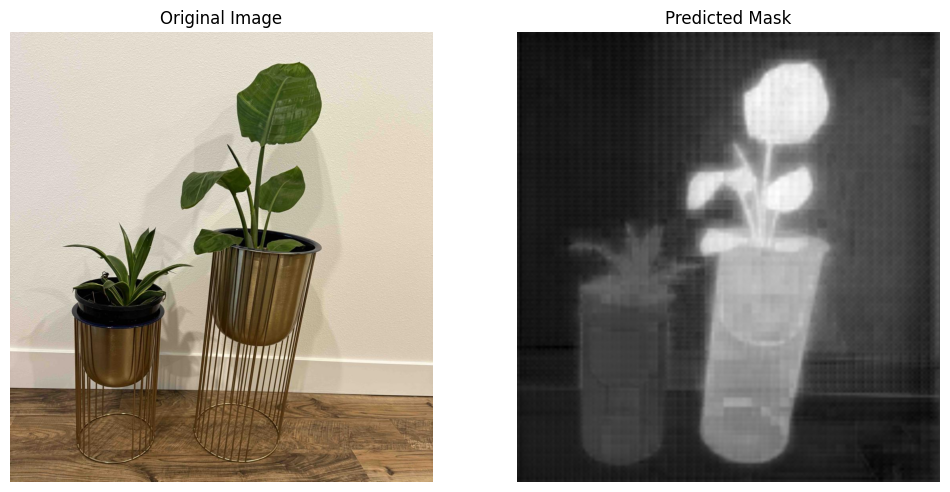

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(Image.open(image_path))
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(pred_masks[0][0].cpu().numpy(), cmap='gray')
axes[1].set_title("Predicted Mask")
axes[1].axis("off")
plt.show()